deep dream

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title('load image')
    return image

# 预处理
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# 反处理
def deprocess(image):
    # image is (H, W, C)
    if isinstance(image, torch.Tensor):
        std = torch.tensor([0.229, 0.224, 0.225], device=device)
        mean = torch.tensor([0.485, 0.456, 0.406], device=device)
    else:
        std = np.array([0.229, 0.224, 0.225])
        mean = np.array([0.485, 0.456, 0.406])
    img = image * std + mean
    return img

In [10]:
model = models.vgg19(pretrained=True)
model.to(device)
# print(model)
print('------')
modulelist = [x for x in model.modules() if type(x) not in (nn.Sequential, models.VGG)]
for idx, m in enumerate(modulelist):
    print(idx, '-', m)
print(len(modulelist))

------
0 - Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 - ReLU(inplace=True)
2 - Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 - ReLU(inplace=True)
4 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 - Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 - ReLU(inplace=True)
7 - Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 - ReLU(inplace=True)
9 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 - ReLU(inplace=True)
12 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 - ReLU(inplace=True)
14 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 - ReLU(inplace=True)
16 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 - ReLU(inplace=True)
18 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [5]:
def prod(image, layer, iterations, lr):
    input = preprocess(image).unsqueeze(0)
    input = input.to(device).requires_grad_(True)
    model.zero_grad()
    for i in range(iterations):
        out = input
        for j in range(layer):
            out = modulelist[j](out)
        # 以特征值的 L2 为损失值
        loss = out.norm()
        loss.backward()
        # 使得梯度增大
        with torch.no_grad():
            input += lr * input.grad
    
    input = input.squeeze()
    input = input.detach().cpu().numpy()
    # 原本是 (C, W, H) 变成了 (W, H, C)
    input = np.transpose(input, (1, 2, 0))
    input = deprocess(input)
    input = np.clip(input, 0, 1)
    im = Image.fromarray(np.uint8(input * 255))
    return im


In [6]:
def deep_dream(image, layer, iterations, lr, octave_scale=2, num_octaves=20):
    if num_octaves > 0:
        img = image.filter(ImageFilter.GaussianBlur(2))
        if (img.size[0] / octave_scale < 1 or img.size[1] / octave_scale < 1):
            size = img.size
        else:
            size = (int(img.size[0] / octave_scale), int(img.size[1] / octave_scale))
        # 缩小图像
        img = img.resize(size, Image.ANTIALIAS)  # Image.ANTIALIAS 抗锯齿
        img = deep_dream(img, layer, iterations, lr, octave_scale, num_octaves -1)  # 递归
        size = (image.size[0], image.size[1])
        # 放大图像
        img = img.resize(size, Image.ANTIALIAS)
        im = ImageChops.blend(image, img, 0.6)  # 混合
    
    img_result = prod(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

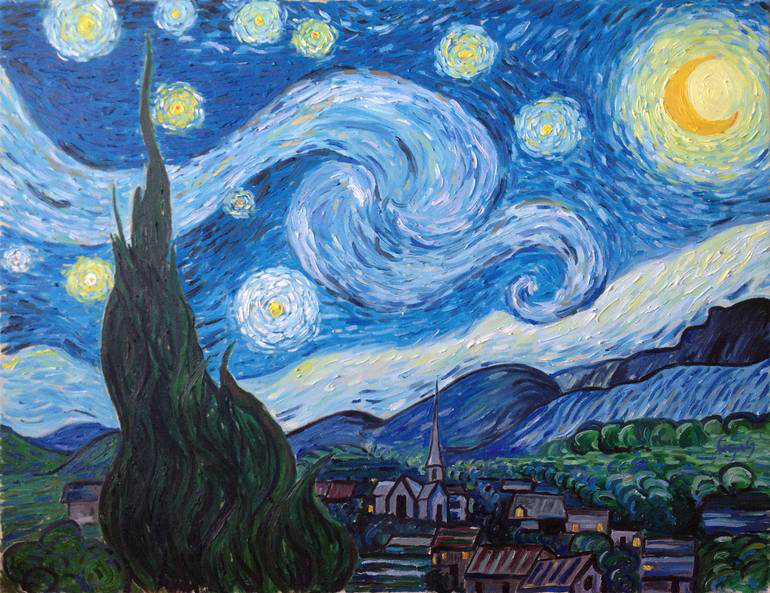

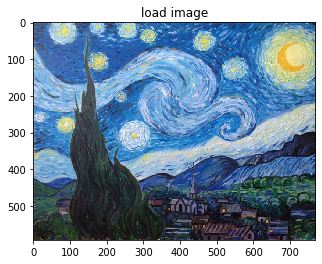

In [31]:
night_sky = load_image('data/deep_dream/starry_night.jpg')
night_sky

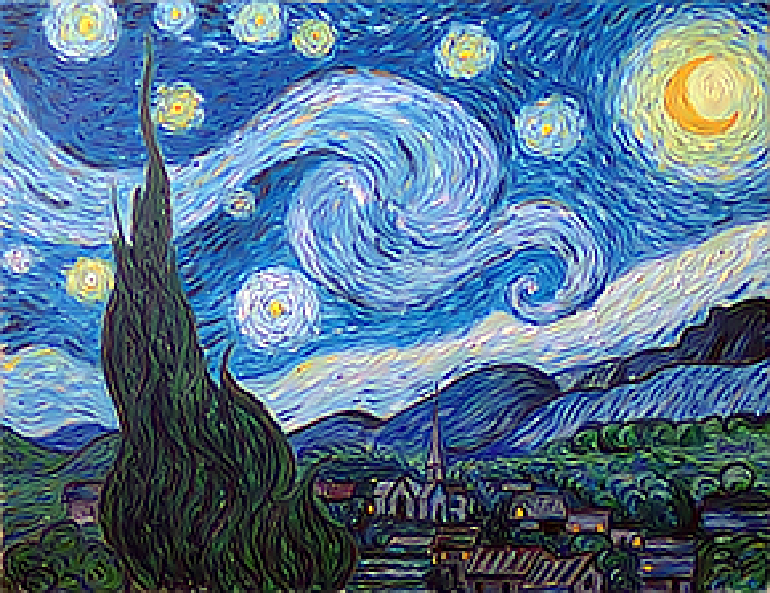

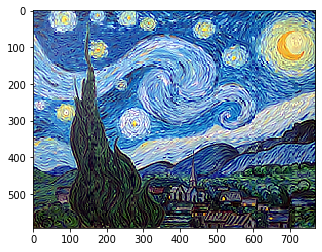

In [27]:
deep_dream(night_sky, layer=6, iterations=6, lr=0.2)

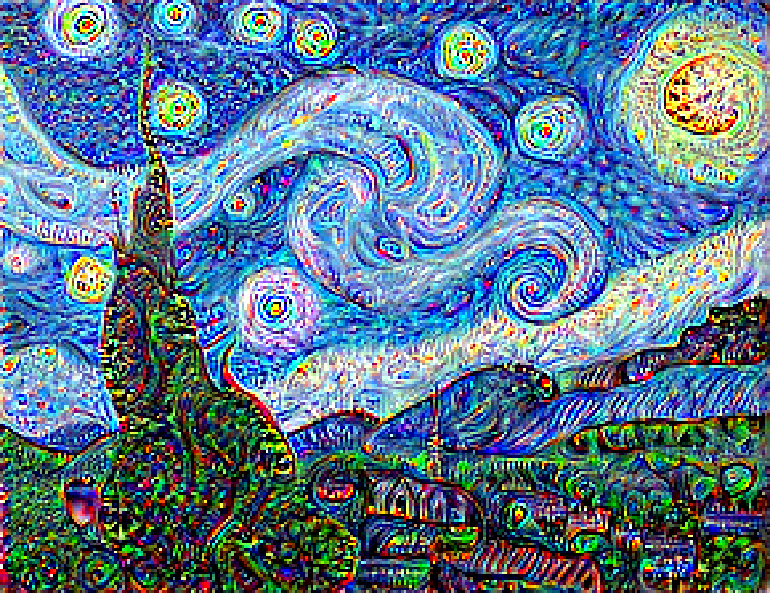

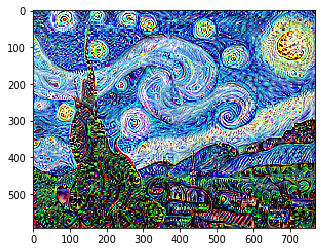

In [28]:
deep_dream(night_sky, layer=17, iterations=6, lr=0.2)

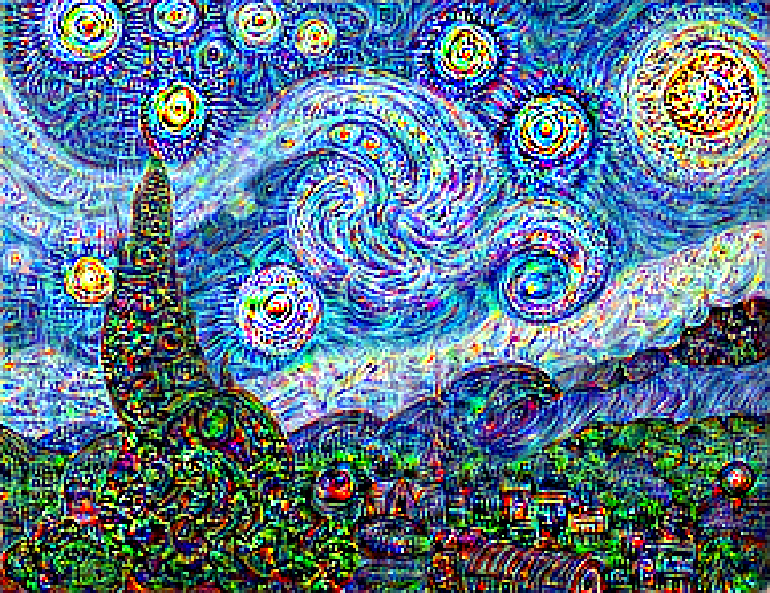

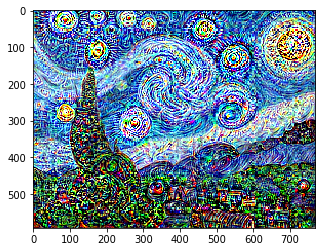

In [29]:
deep_dream(night_sky, layer=26, iterations=6, lr=0.2)

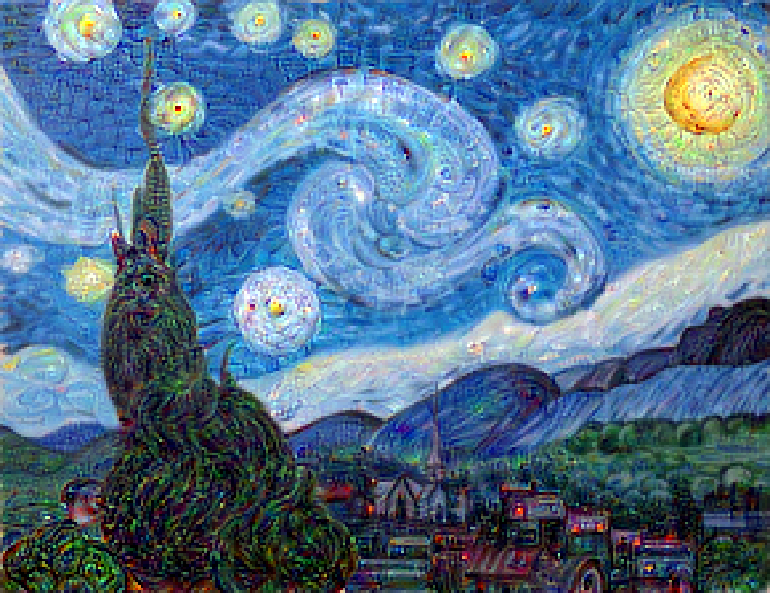

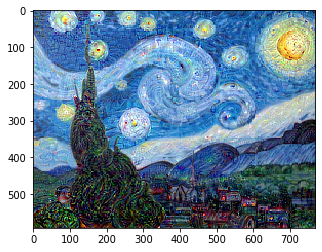

In [21]:
deep_dream(night_sky, layer=32, iterations=6, lr=0.2)

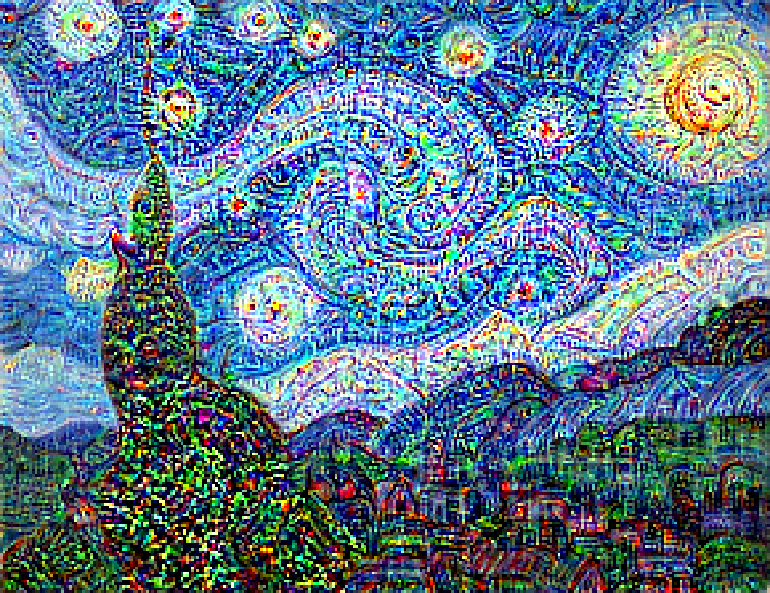

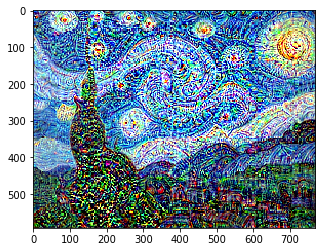

In [24]:
deep_dream(night_sky, layer=35, iterations=6, lr=0.2)

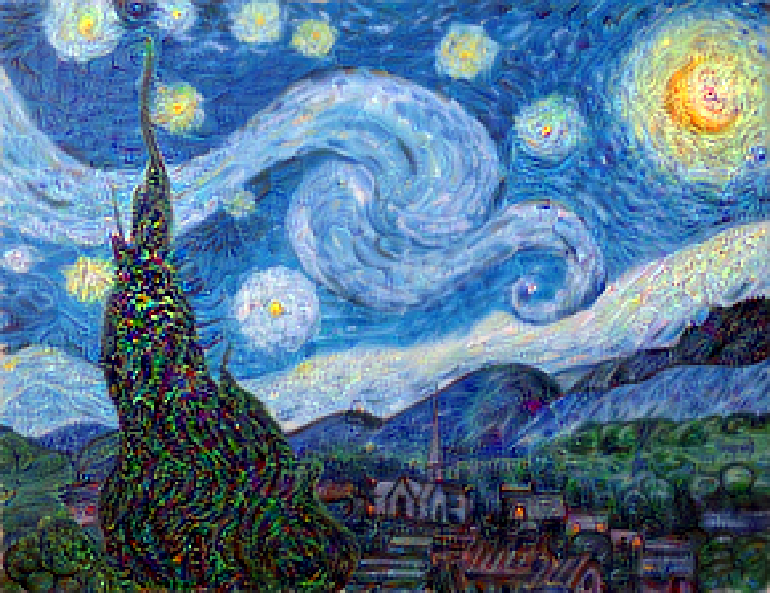

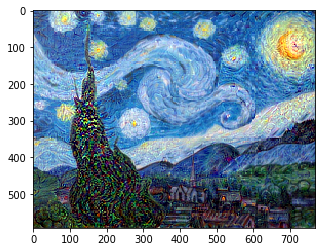

In [25]:
deep_dream(night_sky, layer=36, iterations=6, lr=0.2)

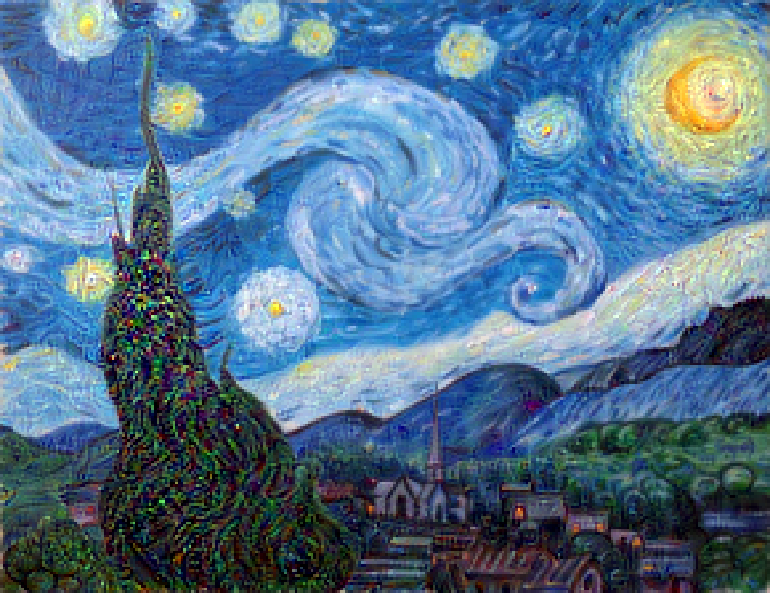

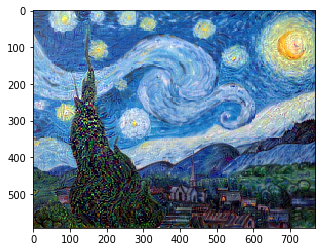

In [26]:
deep_dream(night_sky, layer=37, iterations=6, lr=0.2)